In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf 
import random
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model


import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


print(tf.test.is_gpu_available())
print(tf.config.list_physical_devices('GPU'))
config = tf.compat.v1.ConfigProto()  
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

def seed_tensorflow(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

2025-05-15 03:12:59.013114: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-15 03:12:59.074124: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-15 03:12:59.074151: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-15 03:12:59.076150: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-15 03:12:59.086427: I tensorflow/core/platform/cpu_feature_guar

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-05-15 03:13:01.530539: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:99:00.0, compute capability: 8.9
2025-05-15 03:13:01.539325: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:99:00.0, compute capability: 8.9


In [2]:
seed_tensorflow(1024)
dataname = "sports"
save_path = dataname+".h5"
data = pd.read_csv("./"+dataname+"/"+dataname+".inter", sep="\t", encoding="utf-8")
item_mm = np.load("./"+dataname+"/image_feat.npy")
user_mm = np.load("./"+dataname+"/user_mm.npy")

2025-05-15 03:13:01.561433: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:99:00.0, compute capability: 8.9


In [3]:
data['y'] = (data['rating']>= 5).astype("int32")

In [4]:
data['y']

0         0
1         1
2         0
3         1
4         1
         ..
296332    1
296333    1
296334    1
296335    1
296336    1
Name: y, Length: 296337, dtype: int32

In [5]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# ------------------------------
# 0. 设置随机种子

    
seed_tensorflow(1024)

# ------------------------------
# 1. 数据加载与预处理
# ------------------------------
# 假设 data 是你的 DataFrame，且包含 'userID', 'itemID', 'y' 和 'x_label'
# 例如: data = pd.read_csv("your_data.csv")
num_uid = data['userID'].nunique()
num_vid = data['itemID'].nunique()
print(f"uid: {num_uid}, vid: {num_vid}")

# 根据 x_label 划分数据集
train_df = data[data.x_label == 0]
val_df   = data[data.x_label == 1]
test_df  = data[data.x_label == 2]

print("训练集样本数:", len(train_df))
print("验证集样本数:", len(val_df))
print("测试集样本数:", len(test_df))

# 将 DataFrame 转换为 tf.data.Dataset（返回 features 字典和标签张量）
def df_to_dataset(df, feature_cols, label_col, shuffle=True, batch_size=128):
    features = { key: df[key].values for key in feature_cols }
    labels   = df[label_col].values
    ds = tf.data.Dataset.from_tensor_slices((features, labels))
    if shuffle:
         ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

feature_cols = ['userID', 'itemID']
label_col    = 'y'
BATCH_SIZE   = 32

train_dataset = df_to_dataset(train_df, feature_cols, label_col, shuffle=True, batch_size=BATCH_SIZE)
val_dataset   = df_to_dataset(val_df, feature_cols, label_col, shuffle=False, batch_size=BATCH_SIZE)
test_dataset  = df_to_dataset(test_df, feature_cols, label_col, shuffle=False, batch_size=BATCH_SIZE)

2025-05-15 03:13:02.860388: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:99:00.0, compute capability: 8.9
2025-05-15 03:13:02.893224: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:99:00.0, compute capability: 8.9


uid: 35598, vid: 18357
训练集样本数: 218409
验证集样本数: 37899
测试集样本数: 40029


In [6]:
# 0.6875
train_df['itemID']

0         11981
1         15852
2         17787
3             0
4          3369
          ...  
296328    18245
296329    18336
296332    18340
296333    18335
296334    18329
Name: itemID, Length: 218409, dtype: int64

In [7]:
train_df['userID']

0             0
1             0
2             0
3             0
4             0
          ...  
296328    35596
296329    35596
296332    35597
296333    35597
296334    35597
Name: userID, Length: 218409, dtype: int64

In [8]:
train_dataset

<_PrefetchDataset element_spec=({'userID': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'itemID': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

2025-05-15 03:13:04.892678: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:99:00.0, compute capability: 8.9


uid: 35598, vid: 18357
训练集样本数: 218409
验证集样本数: 37899
测试集样本数: 40029
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 userID (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 itemID (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 id_uid_emb (Embedding)      (None, 1, 768)               2733926   ['userID[0][0]']              
                                                          4                                       
                                                                                                  
 id_vid_emb (Embedding)     

2025-05-15 03:13:09.386962: I external/local_xla/xla/service/service.cc:168] XLA service 0x1953f540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-15 03:13:09.386988: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-05-15 03:13:09.395187: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-15 03:13:09.423720: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1747249989.588624   37256 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step 0: total_loss = 0.9801, AUC = 0.5269, gamma_id = 0.5813, omega_id = 1.0000, omega_mm = 0.0021
Step 200: total_loss = 0.6687, AUC = 0.5696, gamma_id = 0.5218, omega_id = 1.0000, omega_mm = 0.0009
Step 400: total_loss = 0.6557, AUC = 0.5816, gamma_id = 0.5189, omega_id = 1.0000, omega_mm = 0.0009
Step 600: total_loss = 0.6507, AUC = 0.5886, gamma_id = 0.5217, omega_id = 1.0000, omega_mm = 0.0009
Step 800: total_loss = 0.6468, AUC = 0.5957, gamma_id = 0.4985, omega_id = 1.0000, omega_mm = 0.0007
Epoch 1: Train Loss = 0.6461, Train AUC = 0.5975, Val Loss = 0.6324, Val AUC = 0.6295
Best model updated at epoch 1 with val loss inf

Start of epoch 2
Step 0: total_loss = 0.6024, AUC = 0.7181, gamma_id = 0.5099, omega_id = 1.0000, omega_mm = 0.0008
Step 200: total_loss = 0.5925, AUC = 0.7047, gamma_id = 0.4959, omega_id = 1.0000, omega_mm = 0.0006
Step 400: total_loss = 0.5845, AUC = 0.7164, gamma_id = 0.4902, omega_id = 1.0000, omega_mm = 0.0006
Step 600: total_loss = 0.5793, AUC = 0.7243,

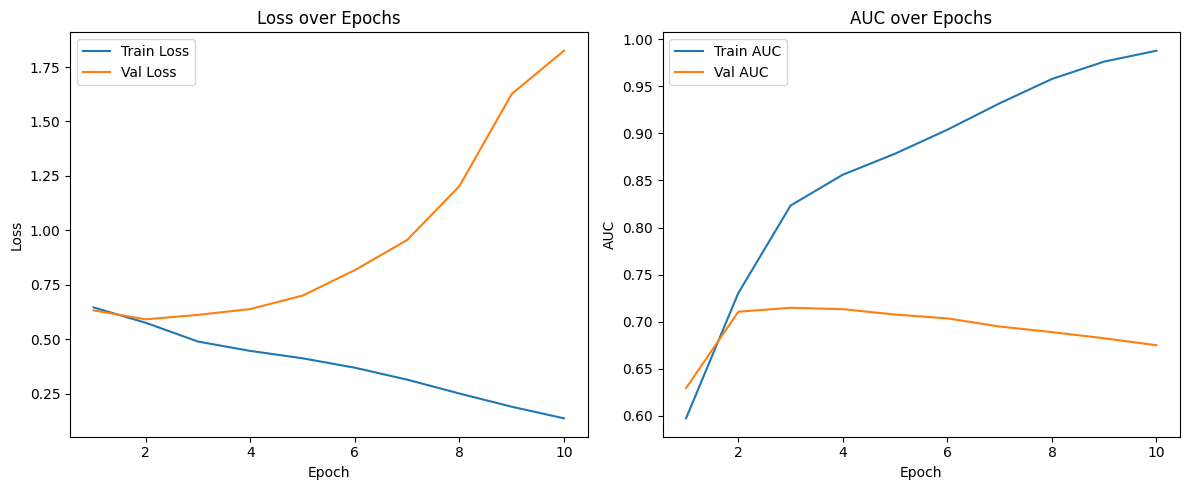

Test Loss: 0.6118, Test AUC: 0.7148


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# ------------------------------
# 0. 设置随机种子

    
seed_tensorflow(1024)

# ------------------------------
# 1. 数据加载与预处理
# ------------------------------
# 假设 data 是你的 DataFrame，且包含 'userID', 'itemID', 'y' 和 'x_label'
# 例如: data = pd.read_csv("your_data.csv")
num_uid = data['userID'].nunique()
num_vid = data['itemID'].nunique()
print(f"uid: {num_uid}, vid: {num_vid}")

# 根据 x_label 划分数据集
train_df = data[data.x_label == 0]
val_df   = data[data.x_label == 1]
test_df  = data[data.x_label == 2]

print("训练集样本数:", len(train_df))
print("验证集样本数:", len(val_df))
print("测试集样本数:", len(test_df))

# 将 DataFrame 转换为 tf.data.Dataset（返回 features 字典和标签张量）
def df_to_dataset(df, feature_cols, label_col, shuffle=True, batch_size=128):
    features = { key: df[key].values for key in feature_cols }
    labels   = df[label_col].values
    ds = tf.data.Dataset.from_tensor_slices((features, labels))
    if shuffle:
         ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

feature_cols = ['userID', 'itemID']
label_col    = 'y'
BATCH_SIZE   = 256

train_dataset = df_to_dataset(train_df, feature_cols, label_col, shuffle=True, batch_size=BATCH_SIZE)
val_dataset   = df_to_dataset(val_df, feature_cols, label_col, shuffle=False, batch_size=BATCH_SIZE)
test_dataset  = df_to_dataset(test_df, feature_cols, label_col, shuffle=False, batch_size=BATCH_SIZE)

# ------------------------------
# 2. 定义 Embedding 层及 MLP 模块（用 MLP 替代 DCN）
# ------------------------------
uid_emb_dim = 768
vid_emb_dim = 768

# 这里假设 user_mm 与 item_mm 已经预加载好相应的权重（类型为 numpy.array）
# 如果名称不同，请替换为你实际的变量名
# user_mm = ...  
# item_mm = ...

def build_mlp_module(x, name_prefix):
    mlp = layers.Dense(128, activation='relu', name=f"{name_prefix}_dense1")(x)
    mlp = layers.Dense(64, activation='relu', name=f"{name_prefix}_dense2")(mlp)
    return mlp

# ------------------------------
# 3. 构建模型（删除独立分量分类，仅使用最终分类器，并输出中间表示用于对齐损失）
# ------------------------------
# 输入层
uid_in = keras.Input(shape=(1,), name="userID")
vid_in = keras.Input(shape=(1,), name="itemID")

# --- ID 分支（使用可训练 embedding，对 userID 与 itemID 均使用） ---
id_uid_emb = layers.Embedding(input_dim=num_uid, output_dim=uid_emb_dim,
                              weights=[user_mm],
                              trainable=True,
                              name="id_uid_emb")(uid_in)    # shape: (batch, 1, uid_emb_dim)
id_vid_emb = layers.Embedding(input_dim=num_vid, output_dim=vid_emb_dim,
                              weights=[item_mm],
                              trainable=True,
                              name="id_vid_emb")(vid_in)     # shape: (batch, 1, vid_emb_dim)
id_uid_feat = layers.Flatten(name="id_uid_flatten")(id_uid_emb)   # (batch, uid_emb_dim)
id_vid_feat = layers.Flatten(name="id_vid_flatten")(id_vid_emb)   # (batch, vid_emb_dim)
id_concat   = layers.Concatenate(name="id_concat")([id_uid_feat, id_vid_feat])  # (batch, uid_emb_dim+vid_emb_dim)
id_mlp      = build_mlp_module(id_concat, name_prefix="id")
id_bn       = id_mlp#layers.BatchNormalization(name="id_bn")(id_mlp)  # 中间表示，用于对齐损失

# --- MM 分支（使用冻结 embedding，对 userID 与 itemID 均使用） ---
mm_uid_emb = layers.Embedding(input_dim=num_uid, output_dim=uid_emb_dim,
                              weights=[user_mm],
                              trainable=False,
                              name="mm_uid_emb")(uid_in)   # (batch, 1, uid_emb_dim)
mm_vid_emb = layers.Embedding(input_dim=num_vid, output_dim=vid_emb_dim,
                              weights=[item_mm],
                              trainable=False,
                              name="mm_vid_emb")(vid_in)    # (batch, 1, vid_emb_dim)
mm_uid_feat = layers.Flatten(name="mm_uid_flatten")(mm_uid_emb)   # (batch, uid_emb_dim)
mm_vid_feat = layers.Flatten(name="mm_vid_flatten")(mm_vid_emb)   # (batch, vid_emb_dim)
mm_concat   = layers.Concatenate(name="mm_concat")([mm_uid_feat, mm_vid_feat])  # (batch, uid_emb_dim+vid_emb_dim)
mm_mlp      = build_mlp_module(mm_concat, name_prefix="mm")
mm_bn       = mm_mlp#layers.BatchNormalization(name="mm_bn")(mm_mlp)  # 中间表示

# --- 最终分类器（自定义层，将两个分支的归一化输出转换为 logit 并相加）
class FinalClassifier(layers.Layer):
    def __init__(self, **kwargs):
        super(FinalClassifier, self).__init__(**kwargs)
    def build(self, input_shape):
        # input_shape: list [id_shape, mm_shape]
        id_shape, mm_shape = input_shape
        d_id = int(id_shape[-1])
        d_mm = int(mm_shape[-1])
        self.W_id = self.add_weight(shape=(d_id, 1),
                                    initializer='glorot_uniform',
                                    trainable=True,
                                    name='W_id')
        self.W_mm = self.add_weight(shape=(d_mm, 1),
                                    initializer='glorot_uniform',
                                    trainable=True,
                                    name='W_mm')
        self.bias = self.add_weight(shape=(1,),
                                    initializer='zeros',
                                    trainable=True,
                                    name='bias')
        super(FinalClassifier, self).build(input_shape)
    def call(self, inputs):
        x_id, x_mm = inputs
        logit_id = tf.matmul(x_id, self.W_id)
        logit_mm = tf.matmul(x_mm, self.W_mm)
        logits = logit_id + logit_mm + self.bias/2.0
        output = tf.sigmoid(logits)
        # 返回最终预测和各分支的 logit
        return output, logit_id, logit_mm

final_output, logit_id, logit_mm = FinalClassifier(name="final_classifier")([id_bn, mm_bn])
# 构造模型：输出包含最终预测、logit 和两个分支的归一化输出（用于计算对齐损失）
model = Model(inputs=[uid_in, vid_in],
              outputs=[final_output, logit_id, logit_mm, id_bn, mm_bn])
model.summary()

# ------------------------------
# ------------------------------
# 5. 自定义训练循环，加入梯度调制和对齐损失
# ------------------------------
# 超参数
eta = 2.0           # 梯度调制的调制强度
alpha_value = 0.1   # 对齐损失权重
learning_rate = 1e-3

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_fn = tf.keras.losses.BinaryCrossentropy()

# 指标
train_loss_metric = tf.keras.metrics.Mean()
train_auc_metric  = tf.keras.metrics.AUC()
val_loss_metric   = tf.keras.metrics.Mean()
val_auc_metric    = tf.keras.metrics.AUC()

# 为了记录每个 epoch 的指标，便于后续可视化
epoch_train_loss_list = []
epoch_train_auc_list  = []
epoch_val_loss_list   = []
epoch_val_auc_list    = []
best_val_loss = float('inf')
best_val_auc = 0
best_epoch = -1

# 用于根据变量名称判断属于哪个分支，对梯度进行调制
def modulate_gradients(grads, vars, omega_id, omega_mm):
    modulated_grads = []
    for g, v in zip(grads, vars):
        if g is None:
            modulated_grads.append(None)
        elif isinstance(g, tf.IndexedSlices):
            if ('id_' in v.name) or ('W_id' in v.name):
                scaled_values = g.values * omega_id
            elif ('mm_' in v.name) or ('W_mm' in v.name):
                scaled_values = g.values * omega_mm
            else:
                scaled_values = g.values
            modulated_grads.append(tf.IndexedSlices(scaled_values, g.indices, g.dense_shape))
        else:
            if ('id_' in v.name) or ('W_id' in v.name):
                modulated_grads.append(g * omega_id)
            elif ('mm_' in v.name) or ('W_mm' in v.name):
                modulated_grads.append(g * omega_mm)
            else:
                modulated_grads.append(g)
    return modulated_grads
def build_pi_and_size(fisher_list):
    flt_list = [tf.reshape(t, [-1]) for t in fisher_list if t is not None]
    if len(flt_list) == 0:
        return None, 0          # 该分支没有可更新参数
    flat = tf.concat(flt_list, axis=0)
    epsilon = 1e-8                                  # 防止出现零概率
    flat = flat + epsilon
    pi = flat / tf.reduce_sum(flat)                 # 重新归一化
    return pi, flat.shape[0]
# -------------------------------------------------
# 为每个可训练变量准备一个 Fisher 累积器 (与变量同形状)
# -------------------------------------------------
def sample_indices(pi_tensor, total_size, budget):
    if total_size == 0 or budget == 0:
        return np.array([], dtype=np.int64)

    # ① 预算不能超过参数个数
    budget = min(budget, total_size)

    # ② 概率重新归一化，确保 sum == 1 且全部 > 0
    pi_np = pi_tensor.numpy()
    pi_np = pi_np / pi_np.sum()

    return np.random.choice(total_size,
                            size=budget,
                            replace=False,
                            p=pi_np)

val_AUC = []
# 自定义训练循环
EPOCHS = 10  # 根据需要调整
c_eps = 1
for epoch in range(EPOCHS):
    print(f"\nStart of epoch {epoch+1}")
    train_loss_metric.reset_states()
    train_auc_metric.reset_states()
    
    for step, (features, labels) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            final_pred, logit_id_batch, logit_mm_batch, id_bn_batch, mm_bn_batch = model(
                [features['userID'], features['itemID']], training=True)
            ce_loss = loss_fn(labels, final_pred)
            total_loss = ce_loss
        
        grads = tape.gradient(total_loss, model.trainable_variables)
        
        labels = tf.cast(labels, tf.float32)
        p_id = tf.sigmoid(logit_id_batch)
        p_mm = tf.sigmoid(logit_mm_batch)
        s_id = labels * p_id + (1 - labels) * (1 - p_id)
        s_mm = labels * p_mm + (1 - labels) * (1 - p_mm)
        sum_s_id = tf.reduce_sum(s_id)
        sum_s_mm = tf.reduce_sum(s_mm) + 1e-8
        #gamma_id = sum_s_id / sum_s_mm
        
        rho_id   = sum_s_id / sum_s_mm   
        rho_mm   = 1.0 / rho_id   
        
        # 采样比例
        gamma_id = tf.exp(rho_mm) / (tf.exp(rho_id) + tf.exp(rho_mm))       ### NEW
        gamma_mm = 1.0 - gamma_id     
        
        # TODO
        # ---------- Fisher 信息 & π ----------
        fisher_id_tensors = []
        fisher_mm_tensors = []

        for g, v in zip(grads, model.trainable_variables):
            v_name = v.name
            # ① 跳过 None 梯度、Embedding 以及共享/非分支参数
            if (g is None) or ('emb' in v_name):
                fisher_id_tensors.append(None)
                fisher_mm_tensors.append(None)
                continue

            # ② 把 IndexedSlices 转成 dense 便于逐参数操作
            if isinstance(g, tf.IndexedSlices):
                g_dense = tf.convert_to_tensor(
                    tf.scatter_nd(tf.expand_dims(g.indices, 1), g.values, v.shape))
            else:
                g_dense = g

            fisher_tensor = tf.square(g_dense)      # (∂log p / ∂θ_j)^2

            # ③ 根据变量归属(ID / MM)分别存
            if ('id_' in v_name) or ('W_id' in v_name):
                fisher_id_tensors.append(fisher_tensor)
                fisher_mm_tensors.append(None)
            elif ('mm_' in v_name) or ('W_mm' in v_name):
                fisher_mm_tensors.append(fisher_tensor)
                fisher_id_tensors.append(None)
            else:                                   # 其它权重保持不动
                fisher_id_tensors.append(None)
                fisher_mm_tensors.append(None)
                
        
        
        # ---------- Fisher → π ----------
        pi_id, size_id = build_pi_and_size(fisher_id_tensors)
        pi_mm, size_mm = build_pi_and_size(fisher_mm_tensors)

        # Step-3 依据 γ 分配预算并随机采样生成 mask
        # ================================================================
        # ① 预算（要更新多少个参数）
        #gamma_id = 0.9
        #gamma_mm = 0.4
        budget_id = int(tf.round(gamma_id * tf.cast(size_id, tf.float32)))
        budget_mm = int(tf.round(gamma_mm * tf.cast(size_mm, tf.float32)))
        
        
        idx_id_keep = sample_indices(pi_id, size_id, budget_id)
        idx_mm_keep = sample_indices(pi_mm, size_mm, budget_mm)

        # ③ 生成展平的缩放系数  w_j = 1/(π_j + c)   —— 未采样参数为 0
        weight_id_flat = np.zeros(size_id, dtype=np.float32)
        weight_mm_flat = np.zeros(size_mm, dtype=np.float32)

        if size_id:
            pi_id_np = pi_id.numpy()
            weight_id_flat[idx_id_keep] = 1.0 / (pi_id_np[idx_id_keep] + c_eps)

        if size_mm:
            pi_mm_np = pi_mm.numpy()
            weight_mm_flat[idx_mm_keep] = 1.0 / (pi_mm_np[idx_mm_keep] + c_eps)

        # ④ 把扁平权重按原张量形状恢复并施加到梯度
        masked_grads = []
        cursor_id = cursor_mm = 0
        for g, v in zip(grads, model.trainable_variables):
            v_name = v.name
            if g is None or ('emb' in v_name):
                masked_grads.append(g)
                continue

            # dense 化
            g_dense = (tf.convert_to_tensor(
                          tf.scatter_nd(tf.expand_dims(g.indices, 1), g.values, v.shape))
                       if isinstance(g, tf.IndexedSlices) else g)
            num_param = tf.size(g_dense).numpy()

            if ('id_' in v_name) or ('W_id' in v.name):
                w_slice = weight_id_flat[cursor_id: cursor_id + num_param]
                cursor_id += num_param
            elif ('mm_' in v_name) or ('W_mm' in v.name):
                w_slice = weight_mm_flat[cursor_mm: cursor_mm + num_param]
                cursor_mm += num_param
            else:                          # 其它共享权重全部保留（权重=1）
                w_slice = np.ones(num_param, dtype=np.float32)

            w_tensor = tf.reshape(tf.convert_to_tensor(w_slice), v.shape)
            g_scaled = g_dense * w_tensor      # 关键：乘以 1/(π_j+c) 或 0

            # 若原梯度是 IndexedSlices，需要再转回稀疏格式
            if isinstance(g, tf.IndexedSlices):
                nz_idx = tf.where(tf.not_equal(w_tensor, 0.0))
                g_scaled = tf.IndexedSlices(
                    values=tf.gather_nd(g_scaled, nz_idx),
                    indices=nz_idx[:, 0],
                    dense_shape=g.dense_shape)

            masked_grads.append(g_scaled)
            
        optimizer.apply_gradients(zip(masked_grads, model.trainable_variables))
        
        omega_id = tf.cond(gamma_id > 1.0,
                           lambda: 1.0 - tf.tanh(eta * gamma_id),
                           lambda: 1.0)
        omega_mm = tf.cond(1/gamma_id > 1.0,
                           lambda: 1.0 - tf.tanh(eta / gamma_id),
                           lambda: 1.0)
        
        #optimizer.apply_gradients(zip(masked_grads, model.trainable_variables))
        #modulated_grads = modulate_gradients(grads, model.trainable_variables, omega_id, omega_mm)
        #optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        train_loss_metric.update_state(total_loss)
        train_auc_metric.update_state(labels, final_pred)
        
        if step % 200 == 0:
            print(f"Step {step}: total_loss = {train_loss_metric.result().numpy():.4f}, "
                  f"AUC = {train_auc_metric.result().numpy():.4f}, "
                  f"gamma_id = {gamma_id:.4f}, omega_id = {omega_id:.4f}, omega_mm = {omega_mm:.4f}")
    
    # 验证阶段
    for features_val, labels_val in test_dataset:
        final_pred_val, _, _, _, _ = model([features_val['userID'], features_val['itemID']], training=False)
        val_loss_metric.update_state(loss_fn(labels_val, final_pred_val))
        val_auc_metric.update_state(labels_val, final_pred_val)
    
    current_train_loss = train_loss_metric.result().numpy()
    current_train_auc  = train_auc_metric.result().numpy()
    current_val_loss   = val_loss_metric.result().numpy()
    current_val_auc    = val_auc_metric.result().numpy()
    
    epoch_train_loss_list.append(current_train_loss)
    epoch_train_auc_list.append(current_train_auc)
    epoch_val_loss_list.append(current_val_loss)
    epoch_val_auc_list.append(current_val_auc)
    
    print(f"Epoch {epoch+1}: Train Loss = {current_train_loss:.4f}, "
          f"Train AUC = {current_train_auc:.4f}, "
          f"Val Loss = {current_val_loss:.4f}, "
          f"Val AUC = {current_val_auc:.4f}")
    val_AUC.append(current_val_auc)
    
    # 保存最优模型权重（以验证损失为准）
    if current_val_auc > best_val_auc:
        best_val_auc = current_val_auc
        best_epoch = epoch
        model.save_weights(save_path)
        print(f"Best model updated at epoch {epoch+1} with val loss {best_val_loss:.4f}")
    
    val_loss_metric.reset_states()
    val_auc_metric.reset_states()

# ------------------------------
# 6. 可视化训练和验证指标
# ------------------------------
epochs_range = range(1, EPOCHS+1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, epoch_train_loss_list, label="Train Loss")
plt.plot(epochs_range, epoch_val_loss_list, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, epoch_train_auc_list, label="Train AUC")
plt.plot(epochs_range, epoch_val_auc_list, label="Val AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title("AUC over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

# ------------------------------
# 7. 加载最优模型权重，并在测试集上评估
# ------------------------------
model.load_weights(save_path)
test_loss_metric = tf.keras.metrics.Mean()
test_auc_metric  = tf.keras.metrics.AUC()

for features_test, labels_test in test_dataset:
    final_pred_test, _, _, _, _ = model([features_test['userID'], features_test['itemID']], training=False)
    test_loss_metric.update_state(loss_fn(labels_test, final_pred_test))
    test_auc_metric.update_state(labels_test, final_pred_test)

print(f"Test Loss: {test_loss_metric.result().numpy():.4f}, Test AUC: {test_auc_metric.result().numpy():.4f}")
